<font size=6><b>Lec00 : 뉴스 감성분석</b></font>
* 감성사전 : https://github.com/ukairia777/finance_sentiment_corpus

In [1]:
from pykrx import stock
from pykrx import bond
import FinanceDataReader as fdr

from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings(action='ignore')
sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)


In [2]:
# ! pip install mecab_python-0.996_ko_0.9.2_msvc-cp38-cp38-win_amd64.whl    #python-mecab-ko

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
# import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
from konlpy.tag import Mecab
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
print('Mecab 명사 추출 :'  , mecab.nouns("열심히 코딩한 당신, 연휴에는 여행을 가봐요")) 

Mecab 명사 추출 : ['코딩', '당신', '연휴', '여행']


# 감성 사전

In [7]:
emo = pd.read_csv('실습10_뉴스지수_감성사전.txt')
emo.head(2)

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to move all production to Russia, although that is where the company is growing.","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로 옮길 계획이 없다고 한다."
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications, the statement said.",테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평방미터 이상의 면적을 단계적으로 개발할 계획이라고 성명은 밝혔다.


In [8]:
del emo['sentence']
emo['labels'] = emo['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
emo[:2]

,labels,kor_sentence
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로 옮길 계획이 없다고 한다."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평방미터 이상의 면적을 단계적으로 개발할 계획이라고 성명은 밝혔다.


In [9]:
emo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   labels        4846 non-null   int64 
 1   kor_sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [10]:
emo.isnull().values.any()


False

In [11]:
emo['kor_sentence'].nunique()

4827

In [12]:
duplicate = emo[emo.duplicated()]
print(duplicate.shape)
duplicate

(16, 2)


,labels,kor_sentence
1099,0,이 발표 내용에 대한 책임은 전적으로 발행자에게 있습니다.
1394,0,"핀란드 헬싱키에 본사를 둔 레민카이넨 그룹은 토목 공학, 건축 계약, 기술 건축 서비스, 건축 자재 산업 등 건설 산업의 모든 부문에서 운영되고 있다."
1416,0,"이 보고서는 블랙 앤 데커, 피스카스, 피스카스 브랜드, 후스크바르나 아웃도어 프로덕츠, K+S 그룹, 료비 테크놀로지스 등 전 세계 주요 및 틈새 업체 614개 기업을 프로파일링하고 있다. 스코츠 미라클그로 컴퍼니와 밴 그룹 주식회사.."
2396,0,알스트롬의 주가는 나스닥 OMX 헬싱키에서 인용되고 있다.
2567,0,SSH 통신 보안 코퍼레이션은 핀란드 헬싱키에 본사를 두고 있다.
2889,0,재정적인 세부사항은 공개되지 않았다.
2890,0,재정적인 세부사항은 공개되지 않았다.
2892,0,금융 조건은 공개되지 않았다.
3050,0,재정적인 세부사항은 제공되지 않았다.
3051,0,재정적인 세부사항은 공개되지 않았다.


In [13]:
# 중복 제거
emo.drop_duplicates(subset=['kor_sentence'], inplace=True)
print('총 샘플의 수 :',len(emo))

총 샘플의 수 : 4827


0    2861
1    1362
2     604
Name: labels, dtype: int64


<AxesSubplot: >

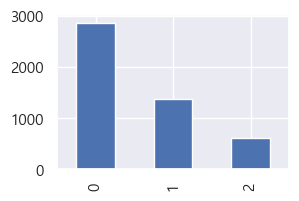

In [14]:
print(emo['labels'].value_counts())
emo['labels'].value_counts().plot(kind='bar', figsize=(3,2))

In [15]:
print(f'중립의 비율 = {round(emo["labels"].value_counts()[0]/len(emo) * 100,3)}%')
print(f'긍정의 비율 = {round(emo["labels"].value_counts()[1]/len(emo) * 100,3)}%')
print(f'부정의 비율 = {round(emo["labels"].value_counts()[2]/len(emo) * 100,3)}%')

중립의 비율 = 59.271%
긍정의 비율 = 28.216%
부정의 비율 = 12.513%


In [ ]:
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
# print('Mecab 명사 추출 :'  , mecab.nouns("열심히 코딩한 당신, 연휴에는 여행을 가봐요")) 
emo['tokenized'] = emo['kor_sentence'].apply(mecab.nouns)
emo.head(3)

,labels,kor_sentence,tokenized
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로 옮길 계획이 없다고 한다.","[회사, 회사, 성장, 곳, 생산, 러시아, 계획]"
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평방미터 이상의 면적을 단계적으로 개발할 계획이라고 성명은 밝혔다.,"[테크노폴리스, 컴퓨터, 기술, 통신, 분야, 일, 회사, 유치, 만, 평방, 미터, 이상, 면적, 단계, 개발, 계획, 성명]"
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 해고와는 달리 회사는 사무직 직원 수를 줄였다고 일간 포스티메스가 보도했다.","[국제, 전자, 산업, 회사, 엘코, 텍, 탈린, 공장, 수십, 명, 직원, 해고, 이전, 해고, 회사, 사무직, 직원, 수, 일간, 포스, 티, 메스, 보도]"


In [18]:
"""  https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations """
# AttributeError: module 'numpy' has no attribute 'int'.
# ! pip install numpy==1.23.0

'  https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations '

In [20]:
from sklearn.model_selection import train_test_split
X = emo['tokenized']
y = emo['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3861,), (966,), (3861,), (966,))

In [25]:
y_train.value_counts(), y_test.value_counts()

(0    2289
 1    1089
 2     483
 Name: labels, dtype: int64,
 0    572
 1    273
 2    121
 Name: labels, dtype: int64)

# 토큰화

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)
print(X_train_encoded[:5])
print(X_test_encoded[:5])

[[210, 58, 1448, 177, 776, 331, 3, 59], [777, 778, 24, 10], [25, 12, 10], [289, 1449, 144, 62, 361, 387, 362, 1741, 705, 62, 1450, 3, 145], [68, 181, 463, 263]]
[[555, 510, 35, 50, 7, 2, 36], [141, 77, 2976, 1758, 492, 195, 79, 3, 6, 176, 11], [417, 198, 567, 61, 2428, 723, 4, 3584, 65, 632, 2022, 3, 767], [16, 58, 1, 101, 25, 85, 2, 85, 2], [1, 5, 8, 400, 87, 27, 334, 30, 808, 174, 137, 1736, 1, 5, 5, 808, 174, 1, 5, 8, 813, 186, 22]]


In [27]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)
     

5812


본문의 최대 길이 : 36
본문의 평균 길이 : 11.106449106449107


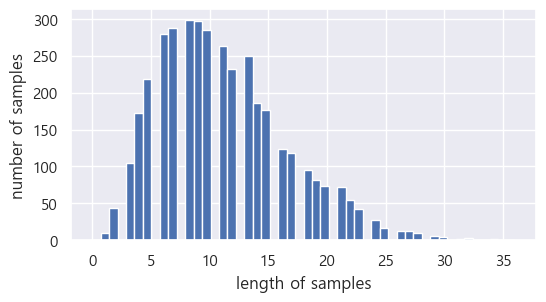

In [30]:
plt.figure(figsize=(6,3))
print('본문의 최대 길이 :',max(len(sent) for sent in X_train))
print('본문의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
     

In [32]:
max_len = 36
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_test_encoded  = pad_sequences(X_test_encoded , maxlen=max_len)
X_train_encoded.shape, X_test_encoded.shape

((3861, 36), (966, 36))

# 모델 생성

In [33]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [34]:
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

In [35]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('실습10_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
96/97 [============================>.] - ETA: 0s - loss: 0.9012 - acc: 0.6081
Epoch 1: val_acc improved from -inf to 0.70763, saving model to 실습10_best_model.h5
97/97 [==============================] - 5s 24ms/step - loss: 0.9011 - acc: 0.6082 - val_loss: 0.7326 - val_acc: 0.7076
Epoch 2/15
96/97 [============================>.] - ETA: 0s - loss: 0.5881 - acc: 0.7559
Epoch 2: val_acc improved from 0.70763 to 0.75679, saving model to 실습10_best_model.h5
97/97 [==============================] - 2s 16ms/step - loss: 0.5877 - acc: 0.7562 - val_loss: 0.6184 - val_acc: 0.7568
Epoch 3/15
95/97 [============================>.] - ETA: 0s - loss: 0.3505 - acc: 0.8694
Epoch 3: val_acc did not improve from 0.75679
97/97 [==============================] - 2s 17ms/step - loss: 0.3496 - acc: 0.8698 - val_loss: 0.7462 - val_acc: 0.7555
Epoch 4/15
93/97 [===========================>..] - ETA: 0s - loss: 0.2207 - acc: 0.9261
Epoch 4: val_acc did not improve from 0.75679
97/97 [================

In [38]:
loaded_model = load_model('실습10_best_model.h5')
loaded_model.evaluate(X_test_encoded, y_test)[1]

31/31 [==============================] - 1s 5ms/step - loss: 0.6049 - acc: 0.7619


0.761904776096344

# 뉴스 

In [42]:
data = pd.read_excel('실습10_빅카인즈뉴스.xlsx')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 20000


In [47]:
data = data[['일자','제목','특성추출(가중치순 상위 50개)']]
data = data.rename(columns={'특성추출(가중치순 상위 50개)': 'news_tokenized'})
data.head(3)

,일자,제목,news_tokenized
0,20230523,내부거래 공시 기준 50억→100억으로 완화,"개정안,내부거래,100억,50억,공정위,시행령,자본총계,계열사,이사회,대기업,특수관계인,관계인,거래법,자본금,게티이미지뱅크,그동안,관계자"
1,20230523,"尹, WTO 사무총장 만나 ""새로운 무역규범 정립 함께 노력""","한국,wto,사무총장,아프리카,이웰라,대통령실,공급망,젊은이들,응고지,이도운,용산,인재들,가트,우리나라,본부장,서울,예측가능성,통상교섭본부장,블록화,발전상황,보조금,자유무역체제,디커플링,정상회의,미국"
2,20230523,"글로벌 반도체 기업 투자 유치 ASM, 한국 제2생산공장 신설","반도체,asm,한국,산업부,김완기,연구개발,화성,경기도,공급망,ald"


In [61]:
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
# print('Mecab 명사 추출 :'  , mecab.nouns("열심히 코딩한 당신, 연휴에는 여행을 가봐요")) 
# data['tokenized'] = data['news'].apply(mecab.nouns)

# tokenizer.fit_on_texts(X_train)
news_encoded = tokenizer.texts_to_sequences(data['news_tokenized'])
news_encoded = pad_sequences(news_encoded, maxlen=max_len)
print(news_encoded.shape, news_encoded[:2])

proba = loaded_model.predict(news_encoded)

(20000, 36) [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 2533 5274  297  971 5282 1143]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 1094 1192 4781 2679   90]]
625/625 [==============================] - 3s 5ms/step


In [67]:
pred = np.argmax(proba, axis=1)
data['pred'] = pred
print( pred.shape, pd.Series(pred).value_counts() )

((20000,),
 0    18554
 1     1271
 2      175
 dtype: int64)

In [ ]:
## replace(['neutral', 'positive', 'negative'],[0, 1, 2])

In [73]:
data[data['pred'] == 0].head()

,일자,제목,news_tokenized,pred
0,20230523,내부거래 공시 기준 50억→100억으로 완화,"개정안,내부거래,100억,50억,공정위,시행령,자본총계,계열사,이사회,대기업,특수관계인,관계인,거래법,자본금,게티이미지뱅크,그동안,관계자",0
1,20230523,"尹, WTO 사무총장 만나 ""새로운 무역규범 정립 함께 노력""","한국,wto,사무총장,아프리카,이웰라,대통령실,공급망,젊은이들,응고지,이도운,용산,인재들,가트,우리나라,본부장,서울,예측가능성,통상교섭본부장,블록화,발전상황,보조금,자유무역체제,디커플링,정상회의,미국",0
2,20230523,"글로벌 반도체 기업 투자 유치 ASM, 한국 제2생산공장 신설","반도체,asm,한국,산업부,김완기,연구개발,화성,경기도,공급망,ald",0
3,20230523,"尹 ""디지털 무역규범 노력"" WTO사무총장 ""韓디지털분야 환상적""","한국,wto,아프리카,사무총장,대통령실,오콘조이웰라,서울,응고지,윤석열,세계무역기구,젊은이들,공급망,나이지리아,인재들,용산,통상교섭본부장,블록화,본부장,총생산,각국,디커플링,우리나라,정상회의,무역체계,이웰라",0
4,20230523,"WTO 사무총장 ""공급망 다변화 위해 개도국서 새 파트너 찾아야""","한국,사무총장,wto,오콘조이웨알라,공급망,개발도상국,이효영,김정일,부사장,안덕근,이재민,서울대,다자무역체제,지정학적,김경한,중구,국가들,보호무역주의,포스코,서울,외교원,응고지,지정학",0


In [74]:
data[data['pred'] == 1].head()

,일자,제목,news_tokenized,pred
19,20230523,"정부, 지원금 부정수급과의 전쟁","부정수급,이승우,우지원,지원금,부정수급범죄,변호사,보조금,벌금형,화요일,법승,공공재정,부정수급행위,관계자,고용노동부,동법,만큼",1
67,20230523,"샤넬, 또 가격 인상 ‘클래식 플랩백 라지’ 가격은 얼마?","샤넬,프랑스,1570만,신발류,1390만,스몰,1480만,1311만,1367만,지갑류,1450만,라지사이즈,가격,인상,클래식,차례,사이즈,제품,라지,플랩,업계,가량,지갑,미디움,명품,신발,브랜드,이날,대표,단행,얼마,라인,판매",1
101,20230523,"​샤넬, 두 달 만에 또 가격 올렸다...'클래식 플립백 라지' 1570만원","샤넬코리아,1570만,샤넬,스몰,플립백,지갑류,1390만,신발류,판매가,유통업,1311만,미디엄,유로,2개월,1367만,1450만,홈페이지,제품별,가격,클래식,사이즈,인상,조정",1
190,20230523,경실련 ‘21대 국회의원 3년간 부동산 재산 증감현황 발표’,"경실련,증감현황,부동산,국회의원,서울,활동가,경제정의실천시민연합,활동가들,종로구,재산,현황,정의,경제,실천,구호,결과,회견,시민,이날,조사,강당,증감,평균,증가",1
201,20230523,조선업 생태계 뒤흔드는 맏형의 저인망식 인력 빼 가기,"한국조선해양,조선업,케이조선,현대,삼성중공업,맏형,조선,경남,중형사,3사,경쟁사,조선업계,대형사,1위,후유증,운반선,hd,lng,조선소,경쟁력,동종사",1


In [70]:
data[data['pred'] == 2].head()

,일자,제목,news_tokenized,pred
200,20230523,관악구 “올 하반기 동행 일자리 참여하세요”,"일자리,고독사,65세,관악구,서울,참여자,주민센터,선발자,개시일,상반기,실직자,저소득층,건강검진",2
225,20230523,​[코로나19] 신규 확진 2만1385명 전주 대비 2286명 감소,"2만,확진자,코로나19,사망자,코로나,인천국제공항,지역감염,전주,위중증,중앙방역대책본부,치명률,풍토병,풍토병화,감소세,1주일,3만,제2여객,1만,엔데믹,진단검사량,의료기관,2주일,감소",2
605,20230522,충청권 지역경제 1분기 부진한 성적표,"충청,충남,충북,세종,반도체,광공업생산,전자부품,화학물질,건설수주,화학제품,고용률,지역경제동향,통신장비,인쇄회로,반도체부품,광공업,경공업,의약품,충청지역,통계청,지역별,성적표,부진,감소",2
996,20230522,무역적자 장기화에 韓경제 '상저하저' 우려 확대(종합),"반도체,중국,무역수지,상반기,장기화,수출액,수입액,경제성장률,성장률",2
1046,20230522,세수 펑크에 허리띠 졸라매는 정부 하반기 재정절벽 온다,"성장률,기재부,상반기,연차총회,간담회,만큼,상저,아시아개발은행,상저하중,반도체,부총리,추경호",2


In [75]:
mecab = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
# print('Mecab 명사 추출 :'  , mecab.nouns("열심히 코딩한 당신, 연휴에는 여행을 가봐요")) 
# data['tokenized'] = data['news'].apply(mecab.nouns)

# tokenizer.fit_on_texts(X_train)
news_encoded = tokenizer.texts_to_sequences(data['제목'])
news_encoded = pad_sequences(news_encoded, maxlen=max_len)
print(news_encoded.shape, news_encoded[:2])

proba = loaded_model.predict(news_encoded)

(20000, 36) [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0 1770  236 5430]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0  725]]
625/625 [==============================] - 3s 6ms/step


In [77]:
pred = np.argmax(proba, axis=1)
data['pred'] = pred
print( pred.shape, pd.Series(pred).value_counts() )

(20000,) 0    18175
1     1476
2      349
dtype: int64


In [ ]:
# ((20000,),
#  0    18554
#  1     1271
#  2      175
#  dtype: int64)

In [78]:
data[data['pred'] == 0].head()

,일자,제목,news_tokenized,pred
0,20230523,내부거래 공시 기준 50억→100억으로 완화,"개정안,내부거래,100억,50억,공정위,시행령,자본총계,계열사,이사회,대기업,특수관계인,관계인,거래법,자본금,게티이미지뱅크,그동안,관계자",0
1,20230523,"尹, WTO 사무총장 만나 ""새로운 무역규범 정립 함께 노력""","한국,wto,사무총장,아프리카,이웰라,대통령실,공급망,젊은이들,응고지,이도운,용산,인재들,가트,우리나라,본부장,서울,예측가능성,통상교섭본부장,블록화,발전상황,보조금,자유무역체제,디커플링,정상회의,미국",0
2,20230523,"글로벌 반도체 기업 투자 유치 ASM, 한국 제2생산공장 신설","반도체,asm,한국,산업부,김완기,연구개발,화성,경기도,공급망,ald",0
3,20230523,"尹 ""디지털 무역규범 노력"" WTO사무총장 ""韓디지털분야 환상적""","한국,wto,아프리카,사무총장,대통령실,오콘조이웰라,서울,응고지,윤석열,세계무역기구,젊은이들,공급망,나이지리아,인재들,용산,통상교섭본부장,블록화,본부장,총생산,각국,디커플링,우리나라,정상회의,무역체계,이웰라",0
4,20230523,"WTO 사무총장 ""공급망 다변화 위해 개도국서 새 파트너 찾아야""","한국,사무총장,wto,오콘조이웨알라,공급망,개발도상국,이효영,김정일,부사장,안덕근,이재민,서울대,다자무역체제,지정학적,김경한,중구,국가들,보호무역주의,포스코,서울,외교원,응고지,지정학",0


In [79]:
data[data['pred'] == 1].head()

,일자,제목,news_tokenized,pred
15,20230523,[자막뉴스] 예상 뒤엎은 폭풍 상승...올라탄 개미는 '눈물 바다',"투자자,이사장,반대매매,증권사,현대경제연구원,개장식,보증금,자막뉴스,이상미,전자인,안전자산,경고음,차액결제거래,상반기,변동성,현대차증권,테마주,여기저기,연구실장,주원,손병두,오창섭,연구원,4조,한국,거래소,눈물,악순환,영상편집,코스피,정작,빚투",1
50,20230523,伊 앞지른 그리스 경제 親시장정책으로 체질 개선,"이탈리아,투자자,독일,집권당,gdp,부사장,슈테판,저금리,한경",1
113,20230523,"WTO 사무총장 ""다자무역체제 회복 위한 한국 역할 중요""","wto,한국,사무총장,응고지,김정일,이효영,안덕근,부사장,서울대,조치들,김경한,이재민,포스코,스퀘어,중구,서울,세계화,외교원,기업들",1
126,20230523,강원도 소비자심리지수 소폭 상승 현 경제상황에 대한 인식과 전망 나아지지 않아,"소비자,소비자심리지수,2포인트,강원,csi,한국은행,소비자동향조사,1포인트,3포인트,상승폭,경제상황,동해,삼척,강릉,원주,태백,춘천,600가구,금리수준전망csi,응답률,경기판단csi,가계저축,부채상황",1
136,20230523,"콘돌 완캐비캐, 한국애니메이션예술인협회와 MOU 체결","콘돌,완캐비캐,한국애니메이션예술인협회,nft,액셀러레이팅,mou,업무협약,서브넷,콘마켓,앱체인,디앱,파라체,디앱들,재산권,핑거,상장사들,협회장,강명구,펀딩,크로스체인,스타트업,서비스들,크라우드,우리나라,계열사,상장사,핀테크,애니메이션단체,한국애니메이션협회,관계자,블록체인,블록체",1


In [80]:
data[data['pred'] == 2].head()

,일자,제목,news_tokenized,pred
49,20230523,"애플 투자의견 하향 ""2분기 실적 부진 전망""","루프캐피털,미국,투자의견,출하량,한경,아난다,500지수,글로벌마켓,목표주가,180달러,바루아,생산량,투자은행,월가,ib,애플,실적",2
56,20230523,지갑 닫고 빚 갚았다...가계 빚 사상 최대 감소,"한국은행,부동산,고금리,미지수,감소세,대출금리,김지선,이상미",2
202,20230523,"​1년째 대중 수출 감소, 아세안도 위축 ""좁아지는 수출길""","중국,우리나라,경쟁력,아세안,중간재,수출액,전경련,반도체,한일,한국,제품군",2
210,20230523,기대인플레 3개월째 하락 내수 회복 기대감,"소비자,기대감,인플레이션,한국은행,소비자심리지수,공공요금,코로나19,엔데믹,전망치,소비자들,유성훈,기대인플레이션율,장기평균,인플레이션율",2
215,20230523,"백화점 매출 감소, 승용차 판매 둔화 ""소비가 위험하다""","연구원,고물가,실질소득,민간소비,백화점,한은,대출금리,승용차,신한투자증권,통계청,월평균,보고서,디레버리징",2


# wordcount

In [83]:
# ! pip install wordcloud
from wordcloud import WordCloud

def my_cloud_chart(prm):
    wc = WordCloud(font_path='C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF'
                   ,background_color="white", max_font_size=60)
    
    try : 
        if type(prm) == str:
            cloud = wc.generate(prm)
        else :
            cloud = wc.generate_from_frequencies(dict(prm))

        # cloud.to_file('test.jpg')

        plt.figure(figsize=(5, 3))
        plt.axis('off')
        plt.imshow(cloud)
        plt.show()
    except:
        print("파라미터는 str 또는 dict만 지원합니다")

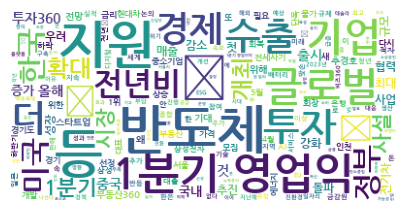

In [84]:
text = " ".join(data['제목'])
my_cloud_chart(text)